<small><i>Author - Yann Vernaz (2017). This notebook was create by [ALpGO](http://www.alpgo.com). Source is on [GitHub](http://github.com/alpgodev/ddos).</i></small>

# DDoS Attack Detection

# Motivation

Datacenter managers are facing serious security problems, either in detecting or preventing networks attacks. The need to detect anomalous traffic and network intrusion, became crucial to be able to protect data and computer systems. The Distributed Denial of Service attacks (DDoS) remain the major problem that a datacenter network manager must cope. Existing intrusion detection rule-based systems are vulnerable when defending against adaptive attacks. Network anomaly detection software based on statistical methods, i.e., Principal Component Analysis, presents a powerful method for detecting a variety of network attacks and other networks anomalies and intrusions.. 

In this _Notebook_, we expose an implementation of the PCA (Principal Component Analysis) method using firewall logs from a datacenter, that hosts real applications.

## Traffic measurement

Each line of the input data (log files) used for traffic measurement are defined by **timestamp**, **source IP** prefixe, **destination IP** prefixe, **source port number**, **destination port number** and **packet size**. We let $n$ denote the number of attribute values and $t$ denote the number of successive time intervals of interest (e.g. 5 minutes). Let $X$ be the $n\times t$ measurement matrix, which denotes the traffic rate in packets/5 minutes in the time series of all attribute values. Thus, each row $i$ denotes the time series of the $i$-th attribute value and each column represents an instance of all attribute values for time interval j.

First, we read the dataset, e.g. Origine-Destination flow matrix $X$.

In [13]:
from __future__ import division, print_function, absolute_import
import numpy as np

# read input data, Origine-Destination flow matrix
X = np.genfromtxt('X_25d.csv', delimiter=',')

# size of flow matrix (number of links and number of time intervals)
n, p = X.shape
print("OD flow matrix holds %d attributes (links) and %d time intervals of 5 minutes (i.e. 25 days)." % X.shape)

OD flow matrix holds 419 attributes (links) and 7200 time intervals of 5 minutes (i.e. 25 days).


We can plot the network traffic volume.

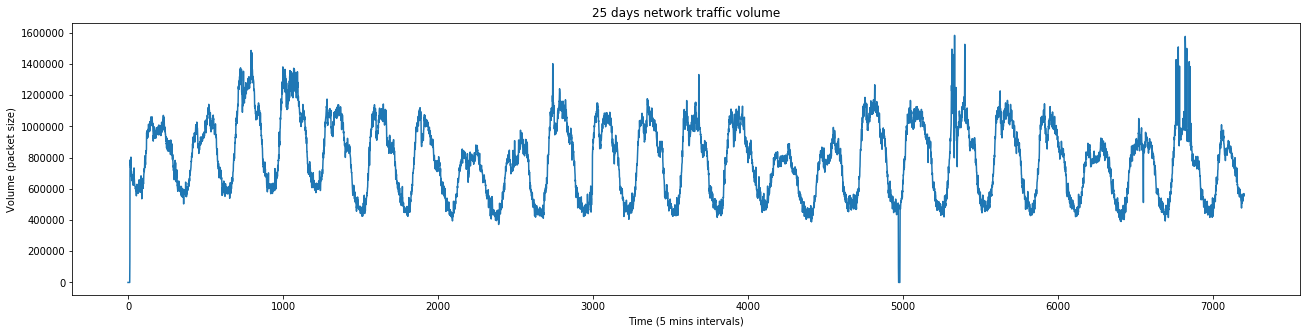

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

# computes traffic volume for each 5 mins intervals (sum over the links)
real_traffic = np.sum(X,axis=0)

plt.figure(figsize=(22,5))
plt.plot(real_traffic)
plt.xlabel('Time (5 mins intervals)')
plt.ylabel('Volume (packet size)')
plt.title('25 days network traffic volume')
plt.show()

In [4]:
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import NumeralTickFormatter

output_notebook()

Loading BokehJS ...

In [1]:
#fig = figure(width=1000,height=300)
#fig.line(range(p),real_traffic, color='#1934E2',line_width=1,line_dash="0 0")
#fig.title = "25 days network traffic"
#fig.grid.grid_line_alpha=0.3
#fig.xaxis.axis_label = "Time (5 mins intervals)"
#fig.yaxis.axis_label = "Volume (packet size)"
#show(fig)  # open

## PCA Methodology

PCA is a statistical procedure that uses an orthogonal transformation to convert a set of observations of possibly correlated variables into a set of values of linearly uncorrelated variables called principal components. In other words, PCA projects a new set of axes that best suit the data, which reduces the amount of dimensions required to classify the given set of data points. By using the new axes, the given set of data points can be described with minimal storage requirements, this is our nominal traffic model. 

The PCA procedure is as follows:

### Step 1 (covariance matrix)

The covariance matrix, which quantifies the covariance between every attribute value pair is equal to: 

$$\Sigma = \frac{1}{T-1}(X-\bar{X})(X-\bar{X})^T$$

Where $\bar{X}$ denote the mean matrix of $X$ for each attributes. The size of $\Sigma$ is equal to $n$ by $n$.

In [5]:
# covariance matrix
cov = np.cov(X)

### Step 2 (Singular Value Decomposition)

By construction $\Sigma$ is a semi-definite matrix (i.e. $\Sigma\succeq 0$) and according to the singular value decomposition theorem, then there exists a factorization of the form 

$$\Sigma = UDV^T$$

where $U$ is an $n\times n$ unitary matrix known as eigenvectors, $D$ is a $n\times n$ diagonal matrix with non-negative real numbers on the diagonal (i.e. $\sigma_i^2$), and the $n\times n$ unitary matrix $V^T$ denotes the transpose of the $n\times n$ unitary matrix $V$. Such a factorization is called a singular value decomposition of $\Sigma$. The diagonal entries $\sigma_i^2$ of $D$ are known as the singular values or eigenvalues of $\Sigma$.

Let $\sigma_i^2$ and $U_i$ denote the $i$-th eigenvalue and eigenvector of covariance matrix $\Sigma$, respectively. The eigenvalue $\sigma_i^2$ of the eigenvector $U_i$ corresponds to the relative amount of variance it encompasses in the direction of $U_i$. The larger the eigenvalue, the more significant its corresponding projected eigenvector is. The eigenvectors are sorted from most to least significance, based on its corresponding eigenvalues. The eigenvector with the most-significant eigenvalue is the first principal component, which has the property that it points in the direction of maximum variance.

In [6]:
import numpy.linalg

# Covariance matrix Singular Value Decomposition 
U, sigma2, Vt = np.linalg.svd(cov, full_matrices=False)

### Step 3 - Choosing the number of components in PCA

Choosing the right number of factors is a crucial problem in PCA. If we select too much factors, we include noise from the sampling fluctuations in the analysis. If we choose too few factors, we lose relevant information, the analysis is incomplete. Unfortunately, there is not an indisputable approach for the determination of the number of factors. As a rule of thumb, we must select only the interpretable factors, knowing that the choice depends heavily on the domain expertise.

We present various approaches for the determination of the right number of factors for PCA based on the correlation matrix. Some of them, such as the Kaiser-Gutman rule or the scree plot  method,  are  very  popular  even  if  they  are  not  really  statistically  sound;  others  seems  more rigorous,  but  seldom  if  ever  used  because  they  are  not  available  in  the popular statistical  software suite.

Note: the correlation matrix is equal to: 

$$\Gamma = [\mbox{diag}(\Sigma)]^{-1/2}\Sigma[\mbox{diag}(\Sigma)]^{-1/2}$$

In [7]:
# Correlation matrix
corr  = numpy.corrcoef(X)

# Correlation matrix Singular Value Decomposition 
U_corr, gamma, Vt_corr = np.linalg.svd(corr, full_matrices=False)

The  challenge is  determining  the number of relevant factors that we need to keep, on the basis of their eigenvalue. This is not really easy. Several aspects should be considered:
the number of instances $n$; the number of variables or attributes $p$; the ratio between the instances and the variables $\frac{p}{n}$; the correlation between the variables; the possible existence of groups of correlated variables. The  ratio  $\frac{p}{n}$  is  an  important  thing.  It  determines  the  stability  of  the  factors. Some  references indicate that  $\frac{p}{n}$ must  be  higher  3  in  order  to  obtain  reliable  results  (Grossman
et  al.,  1991). We have 7200/419 = 17.18 for our dataset.

#### Scree plot

Cattell (1977) proposes to study the plotting of the eigenvalues according to the number of factors.
The idea  is  to  detect  the  "elbow"  in  the  scree  plot,  highlighting  a  modification  of  the structure of the data. To  improve  the  reading  of  this graph,  we  can  use  a  second  graph  where  we  represent  the  evolution  of  the  cumulative  variance explained  by  the  first  $k$  factors of the covariance matrix $\Sigma$.  We  can  detect  also  another  elbow.  It  indicates  that  the  remaining factors correspond to a too low proportion of variance and can be neglected.

We compute the cumulative explained variance by

$$\mbox{cummulative explained variance for } k \mbox{ factors} :=\frac{\sum_{i=1}^k\sigma_i^2}{\sum_{i=1}^n\sigma_i^2}$$

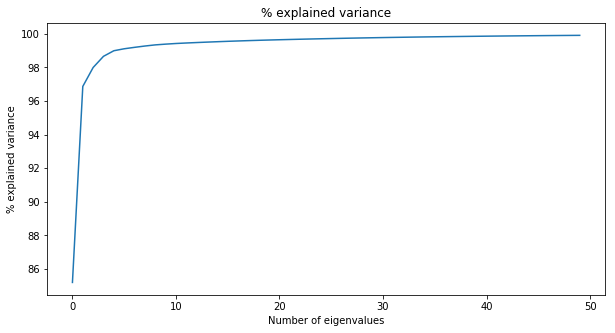

In [8]:
# variance totale 
variance_totale = sigma2.sum()

explained_variance = np.zeros(50)

# cumulative explained variance for i=1,...,50 
explained_variance[0] = sigma2[0]/variance_totale
for i in range(1,50):
    explained_variance[i] = explained_variance[i-1] + sigma2[i]/variance_totale

plt.figure(figsize=(10,5))
plt.plot(100*explained_variance)
plt.xlabel('Number of eigenvalues')
plt.ylabel('% explained variance')
plt.title('% explained variance')
plt.show()

It  seems  that the  solution  with  $k=4$, $k=5$ or $k=6$  factors  is  the  appropriate  one. The  determination  of  the  right  solution  is  not  obvious.

This approach is interesting because it is nuanced. It enables to go beyond the purely arbitrary numerical criterion. But it is complicated to implement because it can be subjective. The detection is not always obvious. We must answer several questions: where is located the elbow? Is it unique? Do we include the factor associated with the elbow in the selection ?

#### Kaiser-Guttman rule and its variant

The  Kaiser-Guttman  rule  is  based  on  a  very  simplistic  idea. If  the  variables  are  independent, the eigenvalues ($\gamma_i$) of the correlation matrix $\Gamma$ for all the factors is 1. Thus, we select the factors which have a correlation's eigenvalues higher to 1.

In [9]:
# number of eigenvalues higher to 1
(gamma>1).sum()

141

For our dataset the number of eigenvalues higher to 1 is 141 ... This threshold is a too permissive criterion in our case, certainly because our data are weakly correlated. A  more  restrictive  rule  overcomes  this  drawback.  It is  based  on  a  statistical  process. We  select  the factors  for  which  their eigenvalue  is significantly  higher  than  1 (cf. Saporta, 2006). At the 5% level (approximately), the critical region is defined as follows

$$\gamma > 1 + 2\sqrt{\frac{n-1}{p-1}}$$

For our dataset, the critical value is:

$$1 + 2\sqrt{\frac{419-1}{7200-1}}=9.2999971176567318$$

In [10]:
critical_value = 1 + 2*np.sqrt((p-1.0)/(n-1))
(gamma>critical_value).sum()

3

It seems that the solution with $k=3$ factors is the appropriate one.

#### Bartlett’s test

1 - Detecting the existence of relevant factors

The Bartlett's sphericity test enables to check if the correlation matrix $\Gamma$ is significantly different to the identity  matrix.  In  our  context,  we  can  use  it  to  determine  if  one  of  the  eigenvalues  at  least  is significantly  different  to  1.  That  means  that there  is at  least  one  relevant  factor. But  we  cannot determine the number of relevant factors. The test statistic is defined as follows:

$$C= -\left(p-1-\frac{2n+5}{6}\right)\log\left|\Gamma\right|= -\left(p-1-\frac{2n+5}{6}\right)\sum_{i=1}^p\log(\gamma_i)$$

Under the null hypothesis, it follows a $\chi^2$ distribution with $[n(n-1)/2]$ degree of freedom.

Note: we use that the determinant of the correlation matrix is equal to the product of the eigenvalues. 

In [17]:
from scipy.stats import chi2

# statistic
C = -(p-1.0-(2.0*n+5.0)/6.0)*(np.log(gamma).sum())

# degree of freedom
df = n*(n-1)/2

# p-value
p_value = chi2.cdf(C , df)

print(p_value)

1.0


Clearly, there is at least one relevant factor!

2 - Detection of the number of relevant factors

A variant of the Bartlett's test for the determination of the right number of factors exists. It was originally  developed for the PCA based on the covariance matrix (cf. Saporta, 2006 and Grossman and al., 1991). But, we can use it in our context. It seems that the test becomes conservative in this case, i.e. it  tends  to  select  too  few  numbers  of  factors (Jackson,  1993 and  Neto  et  al.,  2004). We  will study  its behavior on our dataset.

The process is based on the following idea: we select $k$ factors because the $(n-k)$ eigenvalues of the remaining factors are equals. These eigenvalues correspond to the horizontal part of the scree plot, after the elbow. Here is the null hypothesis of the test:

$$H_0:\gamma_{k+1},...,\gamma_n$$

Unfortunately, the references used vary about the formula of the test statistic. I decided to use the one presented by Saporta (2006), because it is consistent to the Bartlett's test of sphericity when we check the equality of all the factors.

Under the null hypothesis, the $(n-k)$ last eigenvalues are equals. Their arithmetic mean $\bar{\gamma}$ is equal to their geometrical mean $\tilde{\gamma}$. We use the following test statistic to compare them:

$$c_k=\left(p-1-\frac{2n+5}{6}\right)(n-k)\log\left(\frac{\bar{\gamma}}{\tilde{\gamma}}\right)$$
where
$$\bar{\gamma}=\frac{1}{n-k}\sum_{i=k+1}^n\gamma_i\mbox{    and    }\log(\tilde{\gamma})=\frac{1}{n-k}\sum_{i=k+1}^n\log(\gamma_i)$$

Under $H_0$, it follows a $\chi^2$ distribution with $[n(n-1)/2]$ degree of freedom.

Note: this test statistic is consistent to the Bartlett’s sphericity test. Indeed, for $k=0$, we test the equality of all the eigenvalues i.e. $\gamma_k=1$ $\forall k$ and $\bar{\gamma}=1$. We verify that $c_0=C$.

In [31]:
# TODO

Clearly, this test is not appropriate for our dataset. It claims that all the factors are relevant. This is not consistent with the results of the other approaches. It seems that the Bartlett's test is usable only for the determination of the existence of relevant factors, only if the number of instances is not too high. We cannot use it for the determination of the right number of factors (Neto and al., 2004).

#### Broken-stick method

This approach is based on the following idea: under the null hypothesis where the total variance is randomly allocated on the factors, the eigenvalues is distributed according to the broken-stick distribution (Frontier, 1976 and Legendre-Legendre, 1983).

One of the main interests of the approach is that the critical values are very easily to calculate. For the evaluation of a solution with $k$ components, the critical value is:

$$b_k=\sum_{i=k}^n\frac{1}{i}$$

We can calculate the threshold for each value of $k$.

In [19]:
bk = np.zeros(n)
bk[0] = 1
for i in range(1,n):
    bk[i] = bk[i-1] + 1.0/(i+1)

print('i | gamma         | critial value\n')
for i in range(0,9): 
    print(i+1,'|', gamma[i],'|', bk[n-i-1])


i | gamma         | critial value

1 | 63.5035471047 | 6.61627942758
2 | 22.4077864153 | 6.61389279273
3 | 12.0284327402 | 6.61150044824
4 | 8.33186328275 | 6.6091023667
5 | 6.29002073114 | 6.60669852055
6 | 5.70337724129 | 6.60428888199
7 | 4.93387531999 | 6.60187342306
8 | 4.16630240511 | 6.59945211555
9 | 3.81265071478 | 6.59702493108


If we test the relevance of the first factor $(k=1)$, we have a critical value egal to $6.6163$ lower than $\lambda_1=63.50$, so the first factor is accepted.

etc...

According to the broken-stick method, $\bf{k=4}$ components is the right solution. We note however that the $5$th factor is removed narrowly. The broken-stick approach is often efficient (Jackson, 1993). Its drawback is that it does not take into account the size of the sample $p$ and the ratio $p/n$ (Franklin and al., 1995).

Finally, we choose $\bf{k=4}$ for the PCA method.

In [21]:
# number of factors
k = 3

# factors (n by k)
P = U[::,0:k] # note: P'*P = Id

# explained variance
explained_variance = (sigma2[0:k].sum())/sigma2.sum()
print('Explained variance is', 100*explained_variance, \
        '% with', k, 'factors (principal components).')

Explained variance is 97.9914465851 % with 3 factors (principal components).


### Step 4 - Traffic separation into two subspaces

- The modeled or usual traffic is the projection onto the subspace engender by the first $k$ principal components corresponds to the predictable changes in network traffic. We have

$$X_{\mbox{modeled}} = (P*P^T)*X$$

- The abnormal or residual traffic component is the projection onto the complementary subspace. This component will be usefull for applied the anomaly detection scheme. Abnormalities present in an individual OD flows are visible on the projections of residual components while they remain submerged by the total traffic flow when it is projected on the $k$ first components. We have

$$X_{\mbox{abnormal}} = (I - P*P^T)*X$$


In [22]:
import numpy.matlib

# modeled traffic: X_modeled = (P*P')*X
C = np.dot(P,P.T)
modeled_traffic  = np.dot(C,X).sum(axis=0)

# residual traffic: CC = Id - C
CC = np.matlib.identity(n) - C
abnormal_traffic = np.dot(CC,X).sum(axis=0)

Now, we can plot the real traffic and its modeled and abnormal components. 

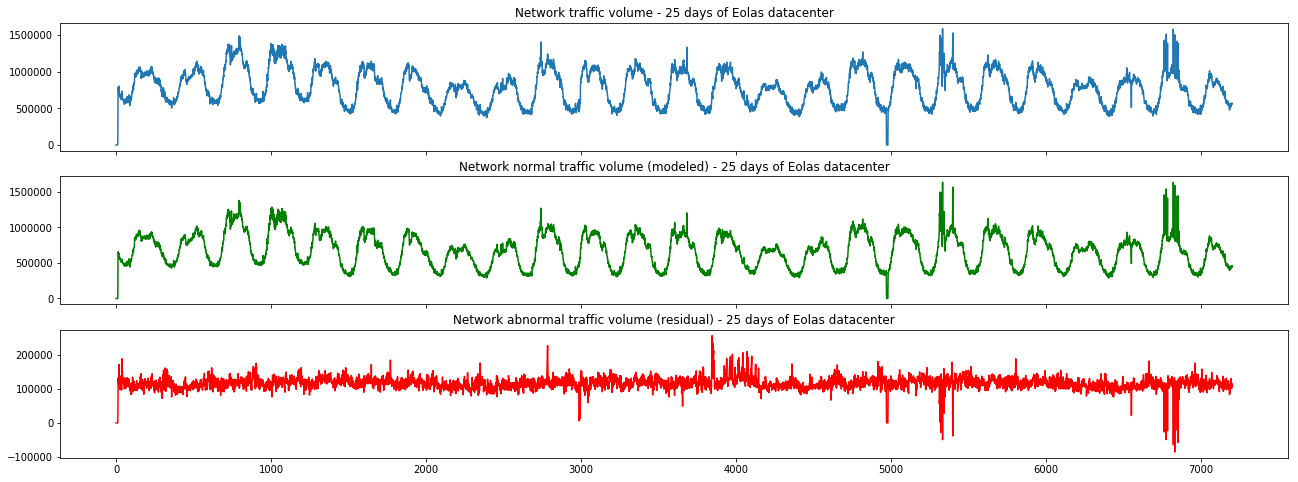

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt

f, axarr = plt.subplots(3, sharex=True, figsize=(22,8))
axarr[0].plot(real_traffic)
axarr[0].set_title('Network traffic volume - 25 days of Eolas datacenter')
axarr[1].plot(modeled_traffic, color='g')
axarr[1].set_title('Network normal traffic volume (modeled) - 25 days of Eolas datacenter')
axarr[2].plot(abnormal_traffic.T, color='r')
axarr[2].set_title('Network abnormal traffic volume (residual) - 25 days of Eolas datacenter')
plt.show()

In the same way, we can plot the principal components.

In [25]:
# mapping of the data to principal axis
H1 = np.dot(X.T,P[::,0])
H1 = H1/np.linalg.norm(H1,1)
H2 = np.dot(X.T,P[::,1])
H2 = H2/np.linalg.norm(H2,1)
H3 = np.dot(X.T,P[::,2])
H3 = H3/np.linalg.norm(H3,1)
H4 = np.dot(X.T,P[::,3])
H4 = H4/np.linalg.norm(H4,1)

F1 = np.dot(X.T,U[::,k])
F1 = F1/np.linalg.norm(F1,1)
F2 = np.dot(X.T,U[::,k+1])
F2 = F2/np.linalg.norm(F2,1)
F3 = np.dot(X.T,U[::,k+2])
F3 = F3/np.linalg.norm(F3,1)
F4 = np.dot(X.T,U[::,k+3])
F4 = F4/np.linalg.norm(F4,1)

# plot
f, axarr = plt.subplots(9, sharex=True, figsize=(24,20))
axarr[0].plot(real_traffic)
axarr[0].set_title('Real network traffic volume')

axarr[1].plot(H1,'g')
axarr[1].set_title('Normal behavior - 1st Principal Component')
axarr[2].plot(H2,'g')
axarr[2].set_title('Normal behavior - 2nd Principal Component')
axarr[3].plot(H3,'g')
axarr[3].set_title('Normal behavior - 3nd Principal Component')
axarr[4].plot(H4,'g')
axarr[4].set_title('Normal behavior - 4th Principal Component')

axarr[5].plot(F1,'r')
axarr[5].set_title('Anomalous Behavior - 1st Principal Component')
axarr[6].plot(F2,'r')
axarr[6].set_title('Anomalous Behavior - 2nd Principal Component')
axarr[7].plot(F3,'r')
axarr[7].set_title('Anomalous Behavior - 3nd Principal Component')
axarr[8].plot(F4,'r')
axarr[8].set_title('Anomalous Behavior - 4th Principal Component')

plt.show()

IndexError: index 3 is out of bounds for axis 1 with size 3

## Attack detection

After calculating our model, we can use it for our attack detection scheme.

### Abnormality detection

We define the total sum of variations in the residual space:

$$Q=r^Tr\mbox{ where }r=\left(I-PP^T\right)x$$

$r$ is the residual vector, i.e. projection of the observation $x$ into the residual space. The Q statistic is also known as the squared prediction error (SPE), is a squared 2-norm measuring the deviation of the observation to the lower-dimensional PCA representation.

The distribution for the $Q$ statistic has been approximated by Jackson and Mudholkar.

$$Q_\alpha = \phi_1\left[\frac{h_0c_\alpha\sqrt{2\phi_2}}{\phi_1} + 1 + \frac{\phi_2h_0(h_0-1)}{\phi_1^2} \right]^{1/h_0}$$
where
$$\phi_i=\sum_{j=k+1}^p(\sigma_j)^{i}\mbox{, }h_0=1-\frac{2\phi_1\phi_3}{3\phi_2^2}$$
and $c_\alpha$ is the normal deviate corresponding to the $(1-\alpha)$ percentile.

The network traffic for observation $z$ is normal if 
$$Q \leq Q_\alpha$$
otherwise an anomalie is detected !

In [26]:
# Q-statistic of Jackson and Mudholkar
# we may consider network traffic to be normal if Q <= Q(alpha)
# at (1 - alpha) confidence level

import scipy.stats

# phi1, phi2, phi3 and h0
sigma2_residual = sigma2[k:n]
phi1 = sum(np.power(sigma2_residual,0.5))
phi2 = sum(np.power(sigma2_residual,1))
phi3 = sum(np.power(sigma2_residual,1.5))
h0 = 1.0 - (2.0*phi1*phi3)/(3.0*phi2*phi2)

# confidence level : 99%
conf_level = 0.99
percent = scipy.stats.norm.ppf(1-conf_level)

# Qstat
Qstat = phi1*np.power((1.0 + (percent*h0*np.sqrt(2.0*phi2))/phi1 + (phi2*h0*(h0-1.0))/(phi1*phi1)),(1/h0))

def DDoS_Detector (z,CC,Qstat):
    # z = z_modeled + z_residual
    z_residual  = np.dot(CC,z)
    # Squared prediction error
    Q = np.linalg.norm(z_residual,2)
    test = (Q < Qstat)
    if (test):
        print('Normal traffic, we have Q =', Q, '< Qstat =', Qstat)
    else:
        print('WARNING *** Abnormal traffic detected, we have Q =', Q, '> Qstat =', Qstat)

# read some observation z
z = np.genfromtxt('z_normal.csv', delimiter=',')
DDoS_Detector (z,CC,Qstat)

z = np.genfromtxt('z_attack.csv', delimiter=',')
DDoS_Detector (z,CC,Qstat)

Normal traffic, we have Q = 45362.5384107 < Qstat = 66375.6531944
WARNING *** Abnormal traffic detected, we have Q = 110618.315222 > Qstat = 66375.6531944


### Identification

The detection step is (optionally) followed by a step of identifying the origin-destination flows involved in the anomaly detected. Identifying the flow that caused a PCA detection is a fundamentally hard problem. It's a heavy-cost procedure requiring the enumeration of all possible OD flows and the calculation of the associated statistic.

We can use the intrinsic dependency structure among multiple attribute values to quantify the anomaly for each attribute value by discovering which new data that violate the normal dependency structure. 

Since the principal components capture the most variance (e.g., 99% of the total variance) of the nominal traffic data, the data points of legitimate traffic rate measured according to the attribute value should be close to those principal components. The nominal traffic measurement points without a DDoS attack is close to the extracted principal component. Because anomalies doesn’t follow the correlation of nominal traffic, the DDoS attacking traffic values measurement points deviate from those principal components. The more attacking traffic that comes in, the greater the deviation.

Here, we let $z$ denote the current traffic measurement vector. Let 

$$\begin{array}{lllll}
z &=& z_{modeled} &+& z_{residual}\\
  &=& PP^Tz       &+& (I-PP^T)z
 \end{array}$$ 

where $z_{modeled}$ denote the current legitimate and $z_{residual}$ the abnormal or residual traffic estimation vector. DDoS attackers try to launch as much attacking traffic as possible, and the traffic volume of the attribute value shared with attacking traffic increases significantly. On the other hand, the attacker usually does not know the target's nominal traffic profile to mimic the legitimate traffic characteristics, the intrinsic dependency across multiple attribute values in the nominal traffic will be violated. 

The proposed scheme tries to filter out the suspicious traffic that does not obey the intrinsic dependency of nominal traffic. With the above observation, we can reformulate the problem of how to estimate the legitimate probability for each attribute value by a simple optimal problem. The objective is to maximize the legitimate likelihood of current incoming packets with some constraints. First, any element in legitimated traffic vector should not be less than zero and larger than the corresponding element in the current traffic vector $z$. Second, $z_{modeled}$ is on the space of principal components (i.e.  $PP^Tz_{modeled} = z_{modeled}$ ), which is based on the observation that legitimate traffic vectors are usually very close to the principal components. The optimization is a linear program which can be expressed as follows:
$$\begin{array}{lll}
\hat{z}_{modeled} &=& \max\limits_{z_{modeled}}\parallel z_{modeled}\parallel_{L_1} \\
 & \mbox{s.t.} &\\
 & & 0\leq z_{modeled}(i)\leq z(i) \\
 & & PP^Tz_{modeled}=z_{modeled} 
\end{array}$$

In which $\parallel z_{modeled}\parallel_{L_1}=\sum_i |z_{modeled}(i)|$ is the sum of absolute value of each elements of vector $z_{modeled}$. First, any element in legitimated traffic vector $z_{modeled}$ should not be less than zero and larger than the corresponding element in the current traffic vector $z$. Second, the point $z_{modeled}$ is on the space of principal components ( $PP^T z_{modeled} = z_{modeled}$ ). 

Considering that the traffic volume associated with each attribute value is not static, we modif $z$ as $\max(z,\bar{z}+3\sigma)$, where $\bar{z}$ and $\sigma$ are the average and standard deviation vector of the nominal traffic rate associated with each attribute value. The optimal solution can be efficiently solved (this is a standard linear program).  However, the $n$ unknown variables and $3n$ constraints cause a formidable computing requirement ($n$ can be huge). We can transfer the problem to an equivalent that can be written as:

$$\hat{z}_{modeled} := \max_{0\leq Ps \leq z}\parallel Ps\parallel_{L_1}$$

in which, $s$ is a projection $k$-vector that quantifies the distance from the original point to point $z_{modeled}$ along each principal axis. It can be verified that $P^Tz_{modeled} = s$ or $z_{modeled} = Ps$ (using the property $P^TP=Id$). This problem has only $k$ unknown variables and $2k$ constraints ($k \ll n$, e.g., $k=4$ and $n=419$ in our dataset).

In [28]:
import cvxpy as cvx

# solve the problem
#
# z_opt := argmax ||Ps|| s.t. 0 <= P*s <= z
#

# data vector (flow)
z = np.genfromtxt('z_attack.csv', delimiter=',')

# Construct the problem.

# variables
x = cvx.Variable(k)

# objective 
objective = cvx.Maximize(cvx.norm(P*x, 1))

#constraints = [0 <= P*x, P*x <= ips]
constraints = [0 <= x, x <= np.dot(Pt,ips)]
prob = cvx.Problem(objective, constraints)

#  check that problem, constraint, or objective satisfies the DCP rules
print("problem is DCP:", prob.is_dcp())

# The optimal objective is returned by prob.solve().
try:
    res = prob.solve()
except Exception as e:
    print(e)
# The optimal value for x is stored in x.value.
print(x.value)
# The optimal Lagrange multiplier for a constraint
# is stored in constraint.dual_value.
print(constraints[0].dual_value)

# legitimate traffic
zl = P*x.value

# abnormal traffic
za = ips - zl

ImportError: No module named cvxpy

Finally, for attribute value $i$, the legitimate probability (or partial score) is defined as 

$$\mbox{partial_score}:=\frac{\hat{z}_{modeled}(i)}{z(i)}$$

For an incoming packet, we assign a packet score by multiplying the partial score of each attribute value that packet possesses. When a packet comes in, a packet legitimate probability can be calculated by multiplying the legitimate probability for each attribute value together. Once this probability is computed for each packet, selective packet discarding and overload control can be conducted. The key idea is to prioritize packets based on their packet legitimate probability values. We discard a suspicious packet if its packet legitimate probability value is below a adjusted (dynamically) threshold. The selective packet discarding is expected to operate at a time-scale that is equal to the packet arrival time-scale.

## Sensitivity of PCA for Traffic Anomaly Detection

Network-wide anomaly detection based on Principal Component Analysis (PCA) is a powerful method for detecting a wide variety of anomalies. Our study identifies and evaluates four main challenges of using PCA to detect traffic anomalies: 

(i) the false positive rate is very sensitive to small differences in the number of principal components in the normal subspace, 

(ii) the effectiveness of PCA is sensitive to the level of aggregation of the traffic measurements, 

(iii) a large anomaly may inadvertently pollute the normal subspace, 

(iv) correctly identifying which flow triggered the anomaly detector is an inherently challenging problem.

Tuning PCA to operate effectively in practice is difficult and requires more robust techniques.

PCA detects anomalous time bins, not anomalous flows. PCA provides no direct mapping between these subspaces and the original flows, which makes it difficult to identify the flow(s) responsible for the anomaly.

This study suggests that using PCA for traffic anomaly detection is much more difficult than it appears. Before PCA can be used for automated, unsupervised detection of anomalous traffic, we need more effective techniques for determining the dimensionality of the normal subspace, preventing its contamination, and identifying flows responsible for a given PCA detection. In our ongoing work, we are also investigating other statistical techniques that may be able to detect and identify anomalous traffic in a more robust manner.

## References

[1] A. Crawford, S. Green, R. Levy, W. Lo, L. Scott, D. Svetina, M. Thompson, “Evaluation of Parallel Analysis for Determining the Number of Factors”, in Educational and Psychological Measurement, 70(6), pp. 885-901, 2010.

[2] S. Franklin, D. Gibson, P. Robertson, J. Pohlmann, F. Fralish, “Parallel Analysis: A Method for Determining Significant Principal Components”, in Journal of Vegetation Science, Vol. 6, Issue 1, pp. 99-106, 1995.

[3] G. Grossman, D. Nickerson, M. Freeman, “Principal Component Anayses of Assemblage Structure: Utility of Tests based on Eigenvalues”, in Ecology, 72(1), pp. 341-347, 1991.

[4] D. Jackson, “Stopping Rules in Principal Components Analysis: A Comparison of Heuristical and Statistical Approaches”, in Ecology, 74(8), pp. 2204-2214, 1993.

[5] P. Neto, D. Jackson, K. Somers, “How Many Principal Components? Stopping Rules for Determining the Number of Aon-trivial Axes Revisited”, in Computational Statistics & Data Analysis, 49(2005), pp. 974-997, 2004.